# Yelp Data Descriptive Analysis 

#### Extracting and analysing some informaton from the datasets to get some insight for further exploration

In [16]:
import os.path
from pathlib import Path
from pyspark.sql import SparkSession
from boto3.session import Session
import seaborn as sns
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

### Set up Amazon S3 Credentials (Note:- Our access and secret keys are removed for security purposes)

In [3]:
ACCESS_KEY = 'MYACCESSKEY'
SECRET_KEY = 'MYSECRETKEY'
BUCKET_NAME = 'yelpbigdata'
PREFIX = 'root'
MAX_FILES_READ = 4

In [4]:
session = Session(aws_access_key_id=ACCESS_KEY, aws_secret_access_key=SECRET_KEY)

In [5]:
s3 = session.resource('s3')

In [6]:
my_bucket = s3.Bucket(BUCKET_NAME)
print(my_bucket)

s3.Bucket(name='yelpbigdata')


In [7]:
spark = SparkSession.builder.appName('BDF').getOrCreate()

In [8]:
spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", ACCESS_KEY)
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", SECRET_KEY)
spark._jsc.hadoopConfiguration().set("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")
spark._jsc.hadoopConfiguration().set("com.amazonaws.services.s3.enableV4", "true")
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.BasicAWSCredentialsProvider")
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3-eu-west-1.amazonaws.com")

### Download the Data from the S3 Bucket and load into the dataframe

In [9]:
my_bucket.download_file('yelp_business.csv',"business.csv")
my_bucket.download_file('yelp_review.csv',"review.csv")

### Business Dataset

In [12]:
business = spark.read.format("com.databricks.spark.csv").option("wholeFile", "true").option("multiline","true").option("header", "true").option("inferSchema", "true").option("delimiter", ",").option("encoding", "ISO-8859-1").option("charset", "ISO-8859-1").option("quote", "\"").option("escape", "\"").load("/content/business.csv")

#### Distribution of States in Dataset

+-----+-----+
|State|count|
+-----+-----+
|   AZ|60803|
|   NV|39084|
|   ON|36627|
|   OH|16392|
|   NC|16218|
|   PA|12376|
|   QC|10233|
|   AB| 8682|
|   WI| 5525|
|   IL| 2034|
|   SC| 1328|
|   CA|   23|
|   NY|   22|
|   TX|    6|
|   WA|    5|
|   AL|    3|
|   GA|    3|
|   FL|    3|
|   BC|    2|
|   MI|    2|
+-----+-----+
only showing top 20 rows



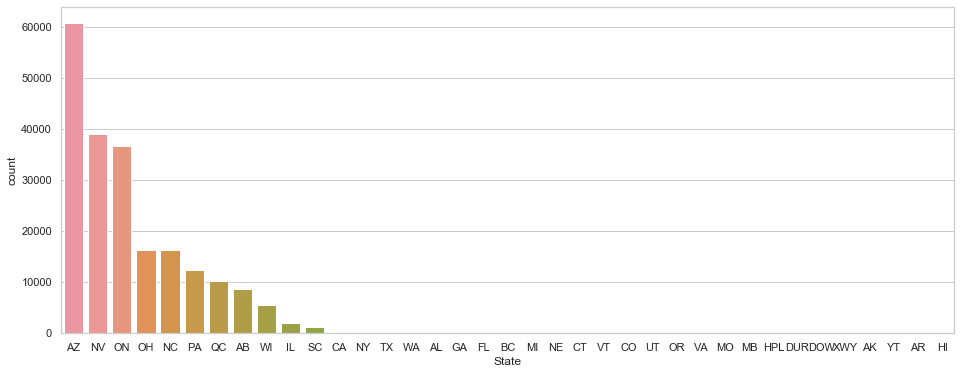

In [17]:
from pyspark.sql.functions import col

# Show the distribution of states in dataset
plot1 = business.groupBy("State").count().sort(col("count").desc())
plot1 = plot1.withColumn('count', col('count').cast('int'))

plot1.show()
plot1pd = plot1.toPandas()

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.barplot(x = "State", y = "count", data = plot1pd)

#### Check the frequency of stars given by users to the restaurent

+-----+-----+
|Stars|count|
+-----+-----+
|  4.0|39199|
|  3.5|38079|
|  4.5|29940|
|  3.0|28634|
|  5.0|27080|
|  2.5|21435|
|  2.0|13124|
|  1.5| 6004|
|  1.0| 5898|
+-----+-----+



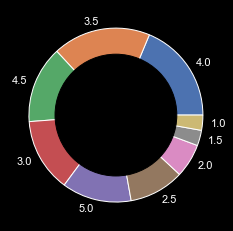

In [24]:
plot2 = business.groupBy("Stars").count().sort(col("count").desc())
plot2 = plot2.withColumn('count', col('count').cast('int'))

plot2.show()
plot2pd = plot2.toPandas()

fig = plt.figure()
fig.patch.set_facecolor('black')
 
# Change color of text
plt.rcParams['text.color'] = 'white'
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='black')
 
# Pieplot + circle on it
plt.pie(plot2pd['count'], labels=plot2pd['Stars'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


### Reviews Dataset

In [25]:
review = spark.read.format("com.databricks.spark.csv").option("wholeFile", "true").option("multiline","true").option("header", "true").option("inferSchema", "true").option("delimiter", ",").option("encoding", "ISO-8859-1").option("charset", "ISO-8859-1").option("quote", "\"").option("escape", "\"").load("/content/review.csv")

In [28]:
# Get the distribution of the count of useful tags on reviews

review.groupBy("useful").count().sort(col("count").desc()).show()

+------+------+
|useful| count|
+------+------+
|     0|542480|
|     1|215635|
|     2| 98813|
|     3| 51211|
|     4| 28620|
|     5| 17479|
|     6| 11464|
|     7|  7797|
|     8|  5474|
|     9|  4083|
|    10|  3112|
|    11|  2309|
|    12|  1859|
|    13|  1449|
|    14|  1138|
|    15|   894|
|    16|   745|
|    17|   630|
|    18|   498|
|    19|   412|
+------+------+
only showing top 20 rows



In [26]:
# Most useful reviews.

review.groupBy("text").avg("useful").sort(col("avg(useful)").desc()).show()

+--------------------+-----------+
|                text|avg(useful)|
+--------------------+-----------+
|Do not use this s...|      354.0|
|I received the ju...|      270.0|
|The Steve Yancey ...|      221.0|
|If you're looking...|      213.0|
|After spending a ...|      206.0|
|Eines der älteste...|      196.0|
|If you're in the ...|      190.0|
|A French traditio...|      185.0|
|I called for a ra...|      181.0|
|Gäbi Coffee and B...|      180.0|
|Mexican classics ...|      178.0|
|"Here's what you ...|      177.0|
|Right C3, LLC is ...|      173.0|
|THE STORY

Mid-Ma...|      164.0|
|Holy bowly! Super...|      160.0|
|Fairmount Bagels ...|      157.0|
|It is funny to me...|      151.0|
|Most of people wh...|      148.0|
|First let me say ...|      148.0|
|Q:  How do you fi...|      146.0|
+--------------------+-----------+
only showing top 20 rows



In [30]:
# Get the distribution of the count of funny tags on reviews

review.groupBy("funny").count().sort(col("count").desc()).show()

+-----+------+
|funny| count|
+-----+------+
|    0|804211|
|    1|119847|
|    2| 35692|
|    3| 15390|
|    4|  7932|
|    5|  4668|
|    6|  3006|
|    7|  2085|
|    8|  1476|
|    9|  1108|
|   10|   785|
|   11|   592|
|   12|   422|
|   13|   375|
|   14|   284|
|   15|   244|
|   16|   205|
|   18|   159|
|   17|   150|
|   19|   123|
+-----+------+
only showing top 20 rows



In [31]:
# Most funny reviews.

review.groupBy("text").avg("funny").sort(col("avg(funny)").desc()).show()

+--------------------+----------+
|                text|avg(funny)|
+--------------------+----------+
|After spending a ...|     171.0|
|Eines der älteste...|     164.0|
|Most of people wh...|     135.0|
|If a college part...|     124.0|
|Maybe it's the al...|     120.0|
|"Here's what you ...|     116.0|
|NEWSFLASH: the Ho...|     115.0|
|Q:  How do you fi...|     112.0|
|Die bekannteste S...|     105.0|
|If you're in the ...|     104.0|
|Give up carbs for...|     103.0|
|THE STORY

Mid-Ma...|     103.0|
|Ooooh!  That "+" ...|     101.0|
|Holy bowly! Super...|      97.0|
|Mexican classics ...|      97.0|
|Are you telling m...|      96.0|
|There are two kin...|      95.0|
|I am a senior gra...|      93.0|
|If you're looking...|      92.0|
|Fast and friendly...|      92.0|
+--------------------+----------+
only showing top 20 rows



In [33]:
# Get the distribution of the count of cool tags on reviews

review.groupBy("cool").count().sort(col("count").desc()).show()

+----+------+
|cool| count|
+----+------+
|   0|758058|
|   1|150031|
|   2| 44716|
|   3| 18053|
|   4|  9061|
|   5|  5335|
|   6|  3403|
|   7|  2343|
|   8|  1656|
|   9|  1235|
|  10|  1012|
|  11|   751|
|  12|   546|
|  13|   450|
|  14|   354|
|  15|   295|
|  16|   261|
|  17|   212|
|  19|   183|
|  18|   169|
+----+------+
only showing top 20 rows



In [34]:
# Most cool reviews.

review.groupBy("text").avg("cool").sort(col("avg(cool)").desc()).show()

+--------------------+---------+
|                text|avg(cool)|
+--------------------+---------+
|If you're looking...|    199.0|
|After spending a ...|    197.0|
|A French traditio...|    188.0|
|Eines der älteste...|    185.0|
|Gäbi Coffee and B...|    183.0|
|If you're in the ...|    178.0|
|Mexican classics ...|    174.0|
|"Here's what you ...|    158.0|
|Holy bowly! Super...|    157.0|
|THE STORY

Mid-Ma...|    156.0|
|Fairmount Bagels ...|    147.0|
|Most of people wh...|    142.0|
|Reathrey Sekong i...|    137.0|
|Are you telling m...|    134.0|
|Created a good 20...|    130.0|
|Tired of people m...|    130.0|
|Q:  How do you fi...|    130.0|
|"Like drinking mi...|    128.0|
|Beer Fact: North ...|    127.0|
|Give up carbs for...|    126.0|
+--------------------+---------+
only showing top 20 rows

